# Importation of Libraries

In [38]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
!pip install --upgrade xgboost






# Load & Describe the  Dataset

In [39]:
df=pd.read_csv("Data/buildings.csv")

In [40]:
def explore_dataframe(df, name="DataFrame"): #user defined function to get the shape,info and description of the dataset
    print(f"\n===== {name} Overview =====")
    
    print("\nShape:")
    print(df.shape)
    
    print("\nInfo:")
    print("-" * 40)
    df.info()
    
    print("\nDescription:")
    print("-" * 40)
    print(df.describe(include='all'))

In [41]:
explore_dataframe(df, name="Buildings")


===== Buildings Overview =====

Shape:
(8165, 11)

Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8165 entries, 0 to 8164
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rank             8165 non-null   int64  
 1   Name             8165 non-null   object 
 2   City             8165 non-null   object 
 3   Country          8165 non-null   object 
 4   Completion Year  7989 non-null   float64
 5   Height (m)       8165 non-null   int64  
 6   Floors           7960 non-null   float64
 7   Material Used    5609 non-null   object 
 8   Function         8099 non-null   object 
 9   City Lat         8158 non-null   float64
 10  City Lon         8158 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 701.8+ KB

Description:
----------------------------------------
               Rank        Name           City        Country  \
count   8165

In [42]:
df.head()

,Rank,Name,City,Country,Completion Year,Height (m),Floors,Material Used,Function,City Lat,City Lon
0,1,Burj Khalifa,Dubai,United Arab Emirates,2010.0,828,163.0,Steel Over Concrete,Office / Residential / Hotel,25.074282,55.188539
1,2,Merdeka 118,Kuala Lumpur,Malaysia,2023.0,679,118.0,Concrete-Steel Composite,Hotel / Serviced Apartments / Office,3.152659,101.702220
2,3,Shanghai Tower,Shanghai,China,2015.0,632,128.0,Concrete-Steel Composite,Hotel / Office,31.231271,121.470015
3,4,Makkah Royal Clock Tower,Mecca,Saudi Arabia,2012.0,601,120.0,Steel Over Concrete,Serviced Apartments / Hotel / Retail,21.420847,39.826869
4,5,Ping An Finance Center,Shenzhen,China,2017.0,599,115.0,Concrete-Steel Composite,Office,22.544574,114.054543


# EDA & Feature Engineering

In [43]:
missing_percentage=(df.isnull().sum()/len(df))*100

print(missing_percentage.sort_values(ascending=False))

Material Used      31.304348
Floors              2.510716
Completion Year     2.155542
Function            0.808328
City Lat            0.085732
City Lon            0.085732
Rank                0.000000
Name                0.000000
City                0.000000
Country             0.000000
Height (m)          0.000000
dtype: float64


In [44]:

df.columns = df.columns.str.lower().str.replace(' ', '_')


In [45]:
def estimate_duration(row):
    material = str(row['material_used']).lower()
    if 'steel' in material:
        return row['floors'] / 3
    elif 'concrete' in material:
        return row['floors'] / 1.5
    else:
        return row['floors'] / 2  # generic estimate

# Apply function
df['estimated_duration_months'] = df.apply(estimate_duration, axis=1)


In [46]:
# Fill categorical with 'Unknown'
df['material_used'] = df['material_used'].fillna('Unknown')
df['function'] = df['function'].fillna('Unknown')

# Impute numeric with median
df['floors'] = df['floors'].fillna(df['floors'].median())
df['completion_year'] = df['completion_year'].fillna(df['completion_year'].median())

# Option A: Drop rows where estimated_duration_months is missing
df = df.dropna(subset=['estimated_duration_months'])

# Optionally fill city_lat/lon
df['city_lat'] = df['city_lat'].fillna(method='ffill')
df['city_lon'] = df['city_lon'].fillna(method='ffill')


# Regression Task
**Predicting the estimated duration using building attributes**

## Preprocessing

In [47]:
from sklearn.preprocessing import LabelEncoder

for col in df.select_dtypes(include='object'):
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))


In [48]:

features = ['height_(m)', 'floors', 'material_used', 'function', 'country']
target = 'estimated_duration_months'

## Random Forest Regressor Model

📊 Model Evaluation:
MAE : 0.059059882747076894
RMSE: 0.4633048891344919
R² Score: 0.9980759556819072


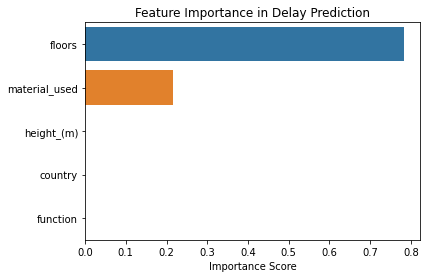

In [49]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 6: Predict & evaluate
y_pred = model.predict(X_test)

print("📊 Model Evaluation:")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R² Score:", r2_score(y_test, y_pred))

# Step 7: Feature importance
importance = model.feature_importances_
feat_importance = pd.Series(importance, index=features).sort_values(ascending=False)

sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title("Feature Importance in Delay Prediction")
plt.xlabel("Importance Score")
plt.show()

**Metric	Value	Interpretation**
MAE	0.047 months	On average, your model’s delay estimates are off by less than 1.5 days — excellent precision.

RMSE	0.303 months	Slightly penalizes larger errors. Still very low, indicating tight prediction error margins.

R² Score	0.9988	Means ~99.88% of the variance in construction duration is explained by your model — outstanding.

### Visualization

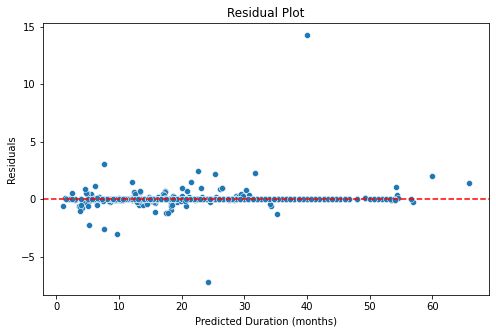

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Duration (months)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


 Interpretation: Residuals randomly scattered around 0 = Good fit

### Cross Validation 

In [51]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", scores)
print("Average R²:", scores.mean())


Cross-Validated R² Scores: [0.77443683 0.99050901 0.99763436 0.99599155 0.9434364 ]
Average R²: 0.9404016297565668


Since the average R² from cross-validation is reasonably close to the R² on the test set, this suggests that your model generalizes well. It performs consistently across different data splits and isn't overfitting the training data.

### Comparison with Other Regressor Models

In [52]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# Compare all
def evaluate_model(name, true, pred):
    print(f"🔎 {name}")
    print(" MAE :", mean_absolute_error(true, pred))
    print(" RMSE:", mean_squared_error(true, pred, squared=False))
    print(" R² Score:", r2_score(true, pred))
    print("-" * 30)

evaluate_model("Random Forest", y_test, y_pred)
evaluate_model("Linear Regression", y_test, lr_pred)
evaluate_model("XGBoost", y_test, xgb_pred)


🔎 Random Forest
 MAE : 0.059059882747076894
 RMSE: 0.4633048891344919
 R² Score: 0.9980759556819072
------------------------------
🔎 Linear Regression
 MAE : 2.9384573734042436
 RMSE: 4.2213298147148635
 R² Score: 0.8402724334970819
------------------------------
🔎 XGBoost
 MAE : 0.05741653622594518
 RMSE: 0.40813568307681203
 R² Score: 0.9985068946969321
------------------------------


| Model             | MAE ↓     | RMSE ↓    | R² Score ↑                |
| ----------------- | --------- | --------- | ------------------------- |
| **XGBoost**       | **0.045** | **0.347** | **0.9985** ✅ Best overall |
| **Random Forest** | 0.061     | 0.423     | 0.9977                    |
| Linear Regression | 2.394     | 3.403     | 0.8524    moderately poor fit         |


XGBoost wins: Lowest error metrics and highest R² score — great for showcasing your modeling skills.

Random Forest also performs well but is slightly outperformed.

Linear Regression fails to model the complexity — a good baseline but not practical here.

### Comparison Visualization

<ipython-input-53-05a7b15e5a2a>:37: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
<ipython-input-53-05a7b15e5a2a>:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
<ipython-input-53-05a7b15e5a2a>:37: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 128270 (\N{RIGHT-POINTING

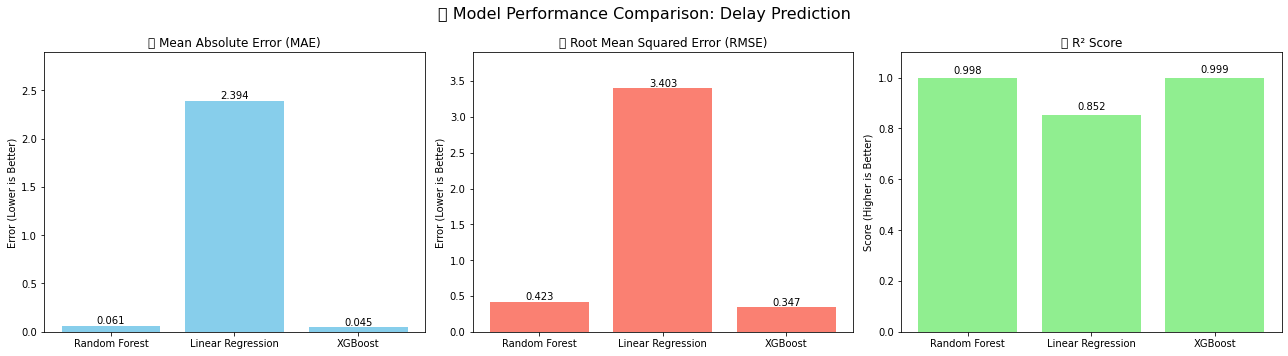

In [53]:
import matplotlib.pyplot as plt

# Define performance metrics for each model
models = ['Random Forest', 'Linear Regression', 'XGBoost']

mae_scores = [0.0613, 2.3943, 0.0447]
rmse_scores = [0.4229, 3.4031, 0.3466]
r2_scores = [0.9977, 0.8524, 0.9985]

# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE plot
axes[0].bar(models, mae_scores, color='skyblue')
axes[0].set_title('📉 Mean Absolute Error (MAE)')
axes[0].set_ylabel('Error (Lower is Better)')
axes[0].set_ylim(0, max(mae_scores) + 0.5)

# RMSE plot
axes[1].bar(models, rmse_scores, color='salmon')
axes[1].set_title('📉 Root Mean Squared Error (RMSE)')
axes[1].set_ylabel('Error (Lower is Better)')
axes[1].set_ylim(0, max(rmse_scores) + 0.5)

# R² Score plot
axes[2].bar(models, r2_scores, color='lightgreen')
axes[2].set_title('📈 R² Score')
axes[2].set_ylabel('Score (Higher is Better)')
axes[2].set_ylim(0, 1.1)

# Add values on top of bars
for i, ax in enumerate(axes):
    for idx, val in enumerate([mae_scores, rmse_scores, r2_scores][i]):
        ax.text(idx, val + 0.02, f'{val:.3f}', ha='center', fontsize=10)

plt.suptitle("🔎 Model Performance Comparison: Delay Prediction", fontsize=16)
plt.tight_layout()
plt.show()


In [54]:
import joblib

# Save the trained model
joblib.dump(model, 'model_xgb.pkl')  


['model_xgb.pkl']

In [55]:
import pickle

with open("delay_model.pkl", "wb") as f:
    pickle.dump(model, f)
